<a href="https://colab.research.google.com/github/ryanmdpeters21/Data-Analysis/blob/main/Football_Analytics_with_Python_chap8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Principal Component Analysis and Clustering: Player Attributes

In [2]:
# PCA is the process of taking a set of features that possess collinearity of some form.
# Collinearity is when two features are correlated with one another.
# For example, 40 times depend on a players weight.
# DIMENSIONALITY REDUCTION: taking a set of features and creating a smaller set of features,
  # based on the fact the features are not completely independent of one another.
# CLUSTERING: the process of dividing data points in smaller groups based on a set of features.
# SUPERVISED LEARNING: require a predefined response variable to be trained on.

In [3]:
# We will obtain our data by using web scraping tools we learned in the last chapter.
# We start by installing and importing our packages.

In [4]:
!pip install pandas
!pip install seaborn
!pip install matplotlib.pyplot
!pip install sklearn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [5]:
# We can now load in our data.
combine_py = pd.DataFrame()
for i in range(2000, 2023 + 1):
  url = (
      'https://www.pro-football-reference.com/draft/' +
      str(i) +
      '-combine.htm'
  )
  web_data = pd.read_html(url)[0]
  web_data['Season'] = i
  web_data = web_data.query('Ht != "Ht"')
  combine_py = pd.concat([combine_py, web_data])

combine_py.reset_index(drop=True, inplace=True)
combine_py.to_csv('combine_data_py.csv', index=False)

combine_py[['Ht-ft', 'Ht-in']] = \
  combine_py['Ht'].str.split('-', expand=True)

combine_py = \
  combine_py\
  .astype({
      'Wt': float,
      '40yd': float,
      'Vertical': float,
      'Bench': float,
      'Broad Jump': float,
      '3Cone': float,
      'Shuttle': float,
      'Ht-ft': float,
      'Ht-in': float
  })

combine_py['Ht'] = (
    combine_py['Ht-ft'] * 12.0 +
    combine_py['Ht-in']
)

combine_py\
  .drop(['Ht-ft', 'Ht-in'], axis=1, inplace=True)

combine_py.describe()

,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Season
count,7970.000000,7975.000000,7416.000000,6162.000000,5197.000000,6086.000000,4873.000000,4993.000000,7999.000000
mean,73.801255,242.550094,4.773901,32.929698,20.736194,114.776536,7.284773,4.400925,2011.698087
std,2.646040,45.296794,0.305084,4.213438,6.364858,9.376346,0.417058,0.266781,6.950760
min,64.000000,144.000000,4.220000,17.500000,2.000000,74.000000,6.280000,3.730000,2000.000000
25%,72.000000,205.000000,4.530000,30.000000,16.000000,109.000000,6.980000,4.200000,2006.000000
50%,74.000000,232.000000,4.690000,33.000000,21.000000,116.000000,7.190000,4.360000,2012.000000
75%,76.000000,279.500000,4.970000,36.000000,25.000000,121.000000,7.530000,4.560000,2018.000000
max,82.000000,384.000000,6.050000,46.500000,49.000000,147.000000,9.120000,5.560000,2023.000000


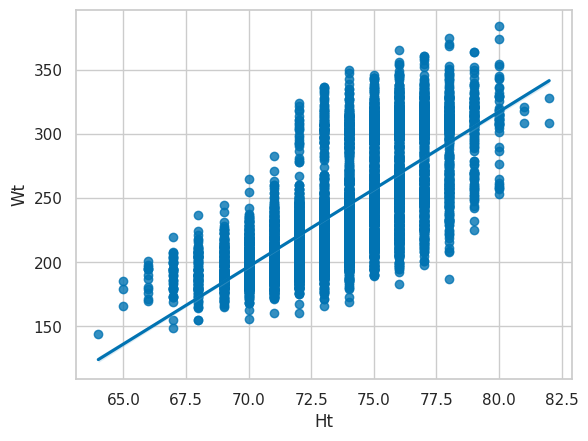

In [6]:
# Let's look at the pair-wise correlations between events.
# First we look at height vs. weight
sns.set_theme(style='whitegrid', palette='colorblind')

sns.regplot(data=combine_py, x='Ht', y='Wt');
plt.show();

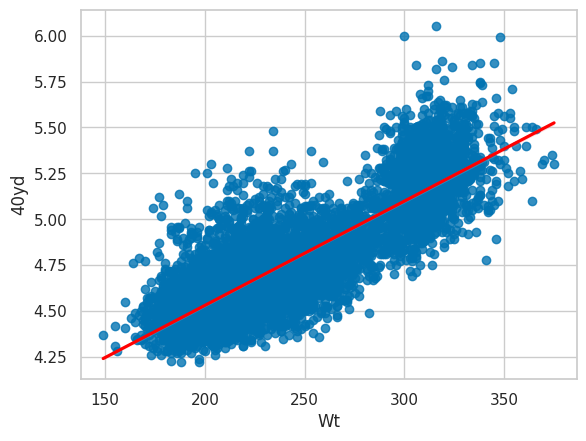

In [7]:
# Being taller generally makes you weigh more. This makes sense.
# Let's look at weight vs. 40-yard dash times
sns.regplot(data=combine_py,
            x='Wt',
            y='40yd',
            line_kws={'color': 'red'});

plt.show()

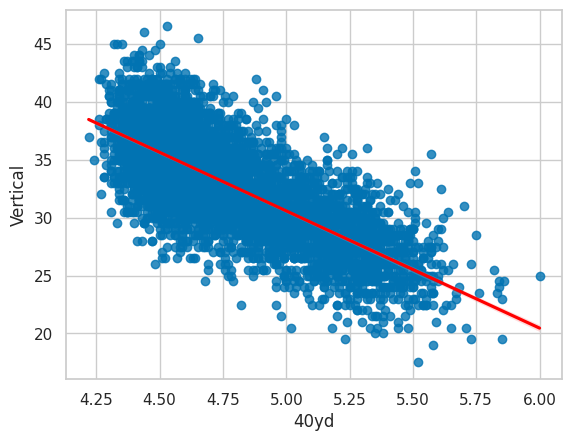

In [8]:
# We can see positive correlation again.
# Notice how the data seems to cluster into two sections: under 225lbs and over 300lbs.
# This is an example of bimodal distribution, rather than a single centre (normal distribution)
# Next, let's look at 40-yd dash vs. vert
sns.regplot(data=combine_py,
            x='40yd',
            y='Vertical',
            line_kws={'color': 'red'});

plt.show()

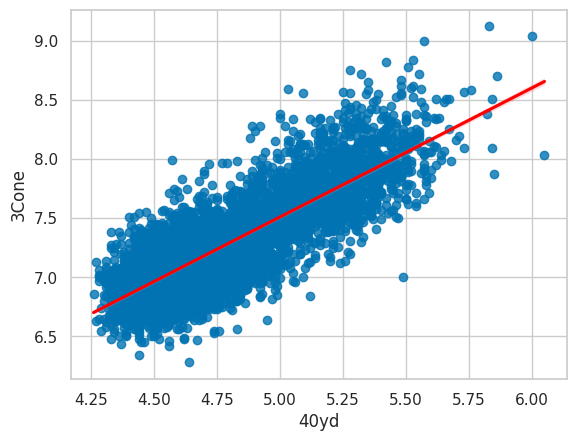

In [9]:
# We can see a negative relationship here: faster players have higher vertical scores.
# Is there a similar relationship between agility and the 40-yd dash?
sns.regplot(data=combine_py,
            x='40yd',
            y='3Cone',
            line_kws={'color': 'red'});

plt.show()

In [10]:
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [11]:
# We can now start PCA, but we need to 'fill in' missing data first
# Only players w/ recorded heights and weights at the combine had data inputted.

import numpy as np
import os
from sklearn.impute import KNNImputer

combine_knn_py_file = 'combine_knn_py.csv'
col_impute = ['Ht', 'Wt', '40yd', 'Vertical',
              'Bench', 'Broad Jump', '3Cone',
              'Shuttle']

if not os.path.isfile(combine_knn_py_file):
  combine_knn_py = combine_py.drop(col_impute, axis=1)
  imputer = KNNImputer(n_neighbors=10)
  knn_out_py = imputer.fit_transform(combine_py[col_impute])
  knn_out_py = pd.DataFrame(knn_out_py)
  knn_out_py.columns = col_impute
  combine_knn_py = pd.concat([combine_knn_py, knn_out_py], axis=1)
  combine_knn_py.to_csv(combine_knn_py_file)

else:
  combine_knn_py = pd.read_csv(combine_knn_py_file)

combine_knn_py.describe()

,Season,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle
count,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000
mean,2011.698087,73.801001,242.531054,4.771854,32.968304,20.116413,114.926717,7.239447,4.373734
std,6.950760,2.643153,45.249358,0.300588,3.855688,5.697521,8.766709,0.374693,0.240283
min,2000.000000,64.000000,144.000000,4.220000,17.500000,2.000000,74.000000,6.280000,3.730000
25%,2006.000000,72.000000,205.000000,4.540000,30.500000,16.000000,109.000000,6.978000,4.210000
50%,2012.000000,74.000000,232.000000,4.690000,33.500000,19.800000,116.500000,7.122000,4.310000
75%,2018.000000,76.000000,279.000000,4.970000,35.500000,24.000000,121.000000,7.450000,4.510000
max,2023.000000,82.000000,384.000000,6.050000,46.500000,49.000000,147.000000,9.120000,5.560000


In [13]:
# Let's fit our PCA.
from sklearn.decomposition import PCA

pca_wt_ht = PCA(svd_solver='full')
wt_ht_py = \
  combine_py[['Wt', 'Ht']]\
  .query('Wt.notnull() & Ht.notnull()')\
  .copy()

pca_fit_wt_ht_py = \
  pca_wt_ht.fit_transform(wt_ht_py)

In [16]:
# Now we want to look at the model details.
# Let's see the variance explained by each of the principal components.

print(pca_wt_ht.explained_variance_ratio_)

[0.99829949 0.00170051]


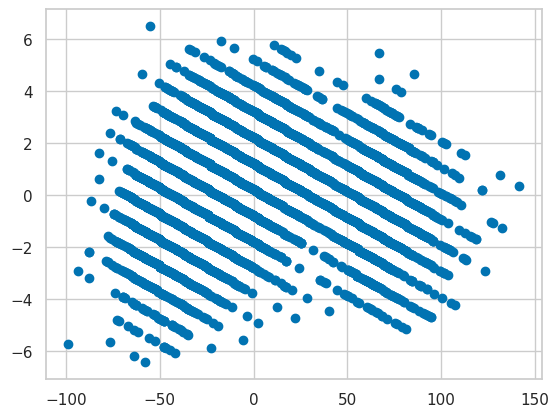

In [17]:
# Both of the outputs show that PC1 (axis of the data) contains 99.8% of the variability in the data.
# This tells us that only the first PC is important for the data.
# Let's take a look at the new representation of the data. We will plot it.
plt.plot(pca_fit_wt_ht_py[:, 0], pca_fit_wt_ht_py[:, 1], 'o');
plt.show();

In [18]:
# This is similar to previous plots, but the data is rotated.
# PCA rotates data to create fewer dimensions of it.
# Let's extract these rotation values.

pca_wt_ht.components_

array([[ 0.9991454 ,  0.04133366],
       [-0.04133366,  0.9991454 ]])

In [21]:
# Now we want to apply Python's built-in algorithms to perform PCA analysis on all data.
# First we will scale the data and then run the PCA.

from sklearn.decomposition import PCA

scaled_combine_knn_py = (
    combine_knn_py[col_impute] -
    combine_knn_py[col_impute].mean()) / \
    combine_knn_py[col_impute].std()

pca = PCA(svd_solver='full')
pca_fit_py = \
  pca.fit_transform(scaled_combine_knn_py)

In [22]:
# The object pca_fit is more of a model object than it is a data object.
# Let's look at the weights for each of the PCs.

rotation = pd.DataFrame(pca.components_, index=col_impute)
print(rotation)

                   0         1         2         3         4         5  \
Ht          0.280603  0.393354  0.390361 -0.341077  0.273423 -0.367238   
Wt          0.506579  0.273181 -0.063583  0.448296  0.552755  0.359507   
40yd       -0.709780 -0.001510 -0.082724  0.030549  0.688515 -0.096008   
Vertical   -0.203595  0.032853  0.012344  0.532170 -0.228706  0.296366   
Bench      -0.142295  0.161116  0.593002  0.505059 -0.157804 -0.369933   
Broad Jump  0.206559 -0.081085 -0.613903  0.276086  0.006766 -0.642036   
3Cone      -0.005273 -0.044896  0.028553  0.251729  0.030935 -0.297506   
Shuttle    -0.237609  0.857330 -0.327470 -0.062315 -0.259688  0.035632   

                   6         7  
Ht          0.381355  0.377841  
Wt         -0.109841 -0.129958  
40yd        0.069129 -0.019596  
Vertical    0.523818  0.509498  
Bench      -0.034761 -0.429064  
Broad Jump  0.276778 -0.093787  
3Cone      -0.677537  0.620686  
Shuttle    -0.162692 -0.047240  


In [24]:
# The first PC weights 40-yd and Wt about the same.
# Most non-size metrics are better when smaller are negative, and those better when bigger are positive.
# Let's look at how much of the proportion of variance is explained in each PC

print(pca.explained_variance_)

[5.60551449 0.83106297 0.62445887 0.3753377  0.21709832 0.1391241
 0.12107331 0.08633025]


In [26]:
# You can see that the first PC handles a significant amount of the variability in the data.
# If we take the SDs and convert them to variances by squaring them and then dividing by sum of all variances.
# We can see the % variance explained by each axis
# Python will do this w/o the extra math.

pca_percent_py = \
  pca.explained_variance_ratio_.round(4) * 100
print(pca_percent_py)

[70.07 10.39  7.81  4.69  2.71  1.74  1.51  1.08]


In [27]:
# Now we want to access the actual PCs.

pca_fit_py = pd.DataFrame(pca_fit_py)
pca_fit_py.columns = \
  ['PC' + str(x + 1) for x in range(len(pca_fit_py.columns))]

combine_knn_py = \
  pd.concat([combine_knn_py, pca_fit_py], axis=1)

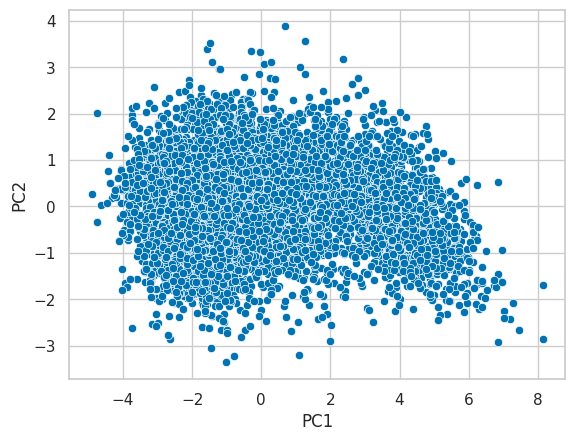

In [31]:
# Now let's graph the first few PCs to see if there are any natural clusters emerging.

sns.scatterplot(data=combine_knn_py,
                x='PC1',
                y='PC2');
plt.show();

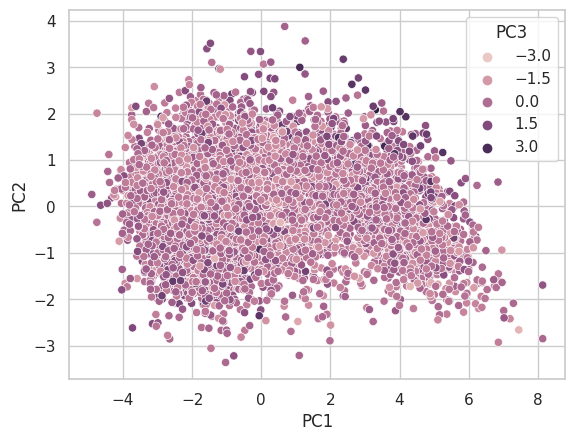

In [32]:
# Let's shade each of the points by the value of the third PC.

sns.scatterplot(data=combine_knn_py,
                x='PC1',
                y='PC2',
                hue='PC3');
plt.show();

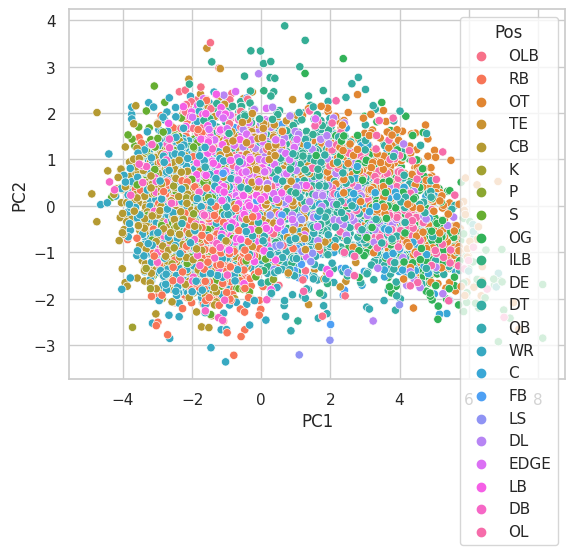

In [33]:
# It seems as though players on the edge of the plot have lower values of PC3.
# Let's shade by position.

sns.scatterplot(data=combine_knn_py,
                x='PC1',
                y='PC2',
                hue='Pos');
plt.show();

In [34]:
# It seems like there is clustering for each of the position groups.
# We will use a clustering algorithm (k-means).
# We will partition the dataset into k clusters in which each observations belong to the cluster w/ nearest mean.

from scipy.cluster.vq import vq, kmeans

k_means_fit_py = \
  kmeans(combine_knn_py[['PC1', 'PC2']], 6, seed = 1234)

# Now we want to attach clusters to the dataset.

combine_knn_py['cluster'] = \
  vq(combine_knn_py[['PC1', 'PC2']], k_means_fit_py[0])[0]

combine_knn_py.head()

,Player,Pos,School,College,Drafted (tm/rnd/yr),Season,Ht,Wt,40yd,Vertical,...,Shuttle,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,cluster
0,John Abraham,OLB,South Carolina,NaN,New York Jets / 1st / 13th pick / 2000,2000,76.0,252.0,4.55,33.80,...,4.224,-0.565969,0.980773,-0.474795,-0.550815,-0.295916,0.345214,-0.147108,0.292072,3
1,Shaun Alexander,RB,Alabama,College Stats,Seattle Seahawks / 1st / 19th pick / 2000,2000,72.0,218.0,4.58,34.35,...,4.250,-1.431579,-0.063408,0.331781,0.007999,-0.141523,-0.080752,-0.073004,0.060097,1
2,Darnell Alford,OT,Boston Col.,NaN,Kansas City Chiefs / 6th / 188th pick / 2000,2000,76.0,334.0,5.56,25.00,...,4.980,5.987965,-1.389487,-0.116521,1.026213,0.323902,0.043452,-0.491836,-0.068816,0
3,Kyle Allamon,TE,Texas Tech,NaN,NaN,2000,74.0,253.0,4.97,29.00,...,4.490,1.411708,-0.929340,-0.022235,-0.598828,0.146888,0.100129,0.328596,-0.059738,2
4,Rashard Anderson,CB,Jackson State,NaN,Carolina Panthers / 1st / 23rd pick / 2000,2000,74.0,206.0,4.55,34.00,...,4.150,-1.537493,0.229250,-0.344051,-0.100172,-0.314806,0.057401,-0.674860,-0.276822,1


In [35]:
# We can't get much info from the head of the data.
# Let's look and see if the clusters bring positions and player types together.
# Let's look at cluster 1.

print(
    combine_knn_py.query('cluster == 1')
    .groupby('Pos')
    .agg({'Ht': ['count', 'mean'], 'Wt': ['count', 'mean']})
)

        Ht               Wt            
     count       mean count        mean
Pos                                    
CB     219  72.442922   219  197.525114
DB      27  72.074074    27  201.074074
DE      13  75.384615    13  250.307692
EDGE     4  74.250000     4  247.000000
FB       8  72.500000     8  235.000000
ILB     19  73.736842    19  237.789474
K        7  73.571429     7  202.714286
LB      42  73.650000    42  234.688095
OLB     76  73.960526    76  236.631579
P       21  74.285714    21  205.904762
QB      39  74.384615    39  216.692308
RB     161  71.222360   161  216.900621
S      217  72.820276   217  209.304147
TE      18  75.555556    18  244.611111
WR     403  73.765509   403  207.673697


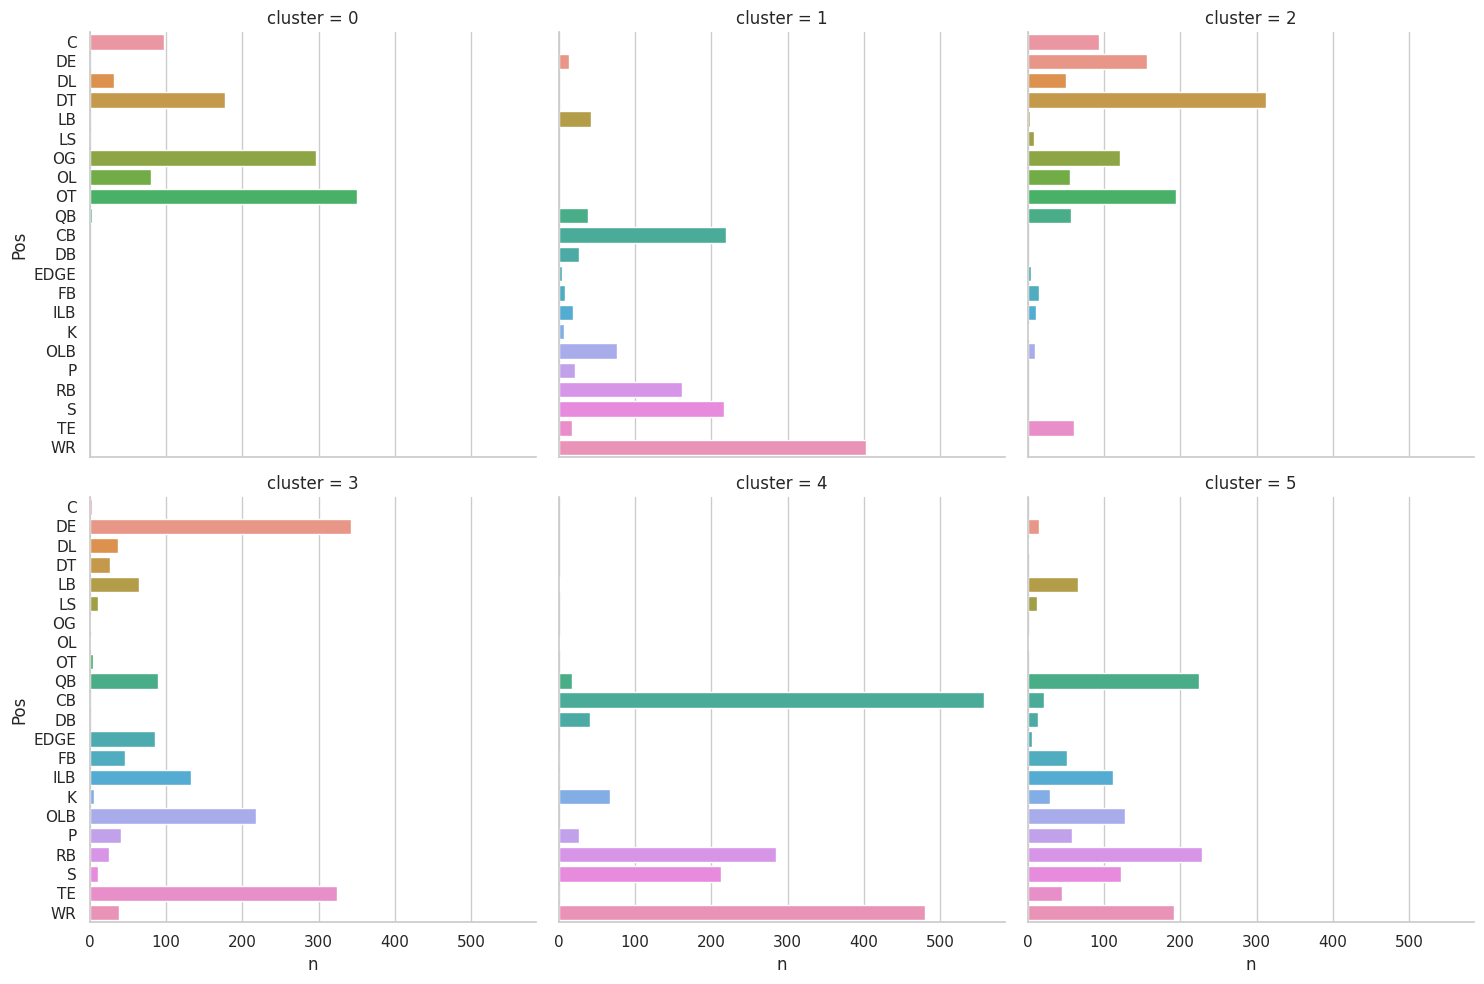

In [36]:
# This shows a bit of everything, but mostly players away from the ball.
# These players are also heavier than most among their own position group.
# Let's look at the summary for all clusters by using a plot.
combine_knn_py_cluster = \
  combine_knn_py\
  .groupby(['cluster', 'Pos'])\
  .agg({'Ht': ['count', 'mean'],
        'Wt': ['mean']}
)

combine_knn_py_cluster.columns = \
  list(map('_'.join, combine_knn_py_cluster.columns))

combine_knn_py_cluster.reset_index(inplace=True)

combine_knn_py_cluster\
  .rename(columns={'Ht_count': 'n',
                   'Ht_mean': 'Ht',
                   'Wt_mean': 'Wt'},
                    inplace=True)

combine_knn_py_cluster.cluster = \
  combine_knn_py_cluster.cluster.astype(str)

sns.catplot(combine_knn_py_cluster, x='n', y='Pos',
            col='cluster', col_wrap=3, kind='bar');
plt.show()

In [38]:
# Cluster 0 is largely bigger players.
# Cluster 1 was shown above.
# Cluster 2 includes similar positions to cluster 0, w/ more DEs and TEs
# Cluster 3 is similar to Cluster 2.
# Cluster 4 is similar to cluster 1, w/ more DBs and WRs
# Cluster 5 includes a lot of QBs and other skill positions.

# Let's look at the summary by cluster and compare weight and height.
combine_knn_py_cluster\
  .groupby('cluster')\
  .agg({'Ht': ['mean'], 'Wt': ['mean']})

,Ht,Wt
,mean,mean
cluster,,
0,75.860474,293.449770
1,73.573629,222.921131
2,74.981939,272.142925
3,75.132763,250.473022
4,71.006182,204.327454
5,73.169902,228.650865
